In [31]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import cv2
import json
from tqdm.auto import tqdm
from PIL import Image

In [8]:
os.getcwd()

'/mnt/processed/private/msds2025/cpt2/ML 3/Final Project'

In [9]:
file_path = '../data/img/full'
sample_files = os.listdir(file_path)[:5]
sample_files

['4a731af15f20724797bf8c50f17f77f40ba98128.jpg',
 'a9bc1949817b9419bbeb18a888eb47f9fad2fa05.jpg',
 '295d882025aebdb0f6d7d8988df57d83c99bf767.jpg',
 'dc9cb25d149c561755331ad627c44d1c5bbb0c09.jpg',
 '1e75aaae5981e0432f442398b282fbe82a6a775c.jpg']

In [10]:
# Check number of files

num_files = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])
print(f"Number of files: {num_files}")

Number of files: 37386


#### Load Metadata

In [11]:
with open('../data/canvas_metadata.json', 'r', encoding='utf-8') as f:
    metadata_list = json.load(f)
df = pd.DataFrame(metadata_list)
print(f'Metadata file shape:\n{df.shape}')
print(f'Columns:\n{list(df.columns)}')
df.head()

Metadata file shape:
(34658, 21)
Columns:
['Id', 'URL', 'Title', 'OriginalTitle', 'Author', 'AuthorLink', 'Date', 'Styles', 'Series', 'SeriesLink', 'Genre', 'GenreLink', 'Media', 'Location', 'Dimensions', 'Description', 'WikiDescription', 'WikiLink', 'Tags', 'image_urls', 'images']


,Id,URL,Title,OriginalTitle,Author,AuthorLink,Date,Styles,Series,SeriesLink,...,GenreLink,Media,Location,Dimensions,Description,WikiDescription,WikiLink,Tags,image_urls,images
0,2,https://www.wikiart.org/en/joe-machine/me-and-...,Me and My Grandfather,None,Joe Machine,https://www.wikiart.org/en/joe-machine,None,"[[Stuckism, https://www.wikiart.org/en/paintin...",None,None,...,https://www.wikiart.org/en/paintings-by-genre/...,"[[acrylic, https://www.wikiart.org/en/painting...",None,100 x 80 cm,,,None,[],[https://uploads1.wikiart.org/00226/images/joe...,[{'url': 'https://uploads1.wikiart.org/00226/i...
1,1,https://www.wikiart.org/en/joe-machine/sex-cri...,Sex Crime Variation 2,None,Joe Machine,https://www.wikiart.org/en/joe-machine,None,"[[Stuckism, https://www.wikiart.org/en/paintin...",None,None,...,https://www.wikiart.org/en/paintings-by-genre/...,"[[acrylic, https://www.wikiart.org/en/painting...",None,99 x 38 cm,,,None,[],[https://uploads2.wikiart.org/00226/images/joe...,[{'url': 'https://uploads2.wikiart.org/00226/i...
2,0,https://www.wikiart.org/en/joe-machine/two-gir...,Two Girlies,None,Joe Machine,https://www.wikiart.org/en/joe-machine,None,"[[Stuckism, https://www.wikiart.org/en/paintin...",None,None,...,https://www.wikiart.org/en/paintings-by-genre/...,"[[acrylic, https://www.wikiart.org/en/painting...",None,122 x 91 cm,,,None,"[female-nude, Human]",[https://uploads2.wikiart.org/00226/images/joe...,[{'url': 'https://uploads2.wikiart.org/00226/i...
3,3,https://www.wikiart.org/en/joe-machine/my-moth...,My Mother's Last Cigarette,None,Joe Machine,https://www.wikiart.org/en/joe-machine,None,"[[Stuckism, https://www.wikiart.org/en/paintin...",None,None,...,https://www.wikiart.org/en/paintings-by-genre/...,"[[acrylic, https://www.wikiart.org/en/painting...",None,100 x 80 cm,,,None,[],[https://uploads4.wikiart.org/00226/images/joe...,[{'url': 'https://uploads4.wikiart.org/00226/i...
4,4,https://www.wikiart.org/en/joe-machine/until-t...,Until the Last Dog is Hung,None,Joe Machine,https://www.wikiart.org/en/joe-machine,None,"[[Stuckism, https://www.wikiart.org/en/paintin...",None,None,...,https://www.wikiart.org/en/paintings-by-genre/...,"[[acrylic, https://www.wikiart.org/en/painting...",None,80 x 100 cm,,,None,"[Mammal, Vertebrate, Dog, Canidae, American pi...",[https://uploads4.wikiart.org/00226/images/joe...,[{'url': 'https://uploads4.wikiart.org/00226/i...


#### Check for Duplicates based on Metadata

In [15]:
# --- Helper function to safely extract image info ---
def get_image_info(image_data_list):
    """
    Extracts path and checksum from the first valid entry in the image_data_list.
    Each item in image_data_list is expected to be a dictionary.
    """
    if isinstance(image_data_list, list) and len(image_data_list) > 0:
        # Assuming we are interested in the first image entry if multiple exist
        first_entry = image_data_list[0]
        if isinstance(first_entry, dict):
            path = first_entry.get('path')
            checksum = first_entry.get('checksum')
            status = first_entry.get('status')
            # Only consider if status is 'downloaded' and path/checksum are present
            if status == 'downloaded' and path and checksum:
                return path, checksum
    return None, None

In [16]:
# --- Main Duplicate Checking Function ---
def find_duplicate_images(df, image_column_name='images'):
    """
    Finds duplicate images in a DataFrame based on checksums and file paths.

    Args:
        df (pd.DataFrame): The DataFrame containing image metadata.
        image_column_name (str): The name of the column holding the image data list.
                                 (e.g., the 'images' column in your case)
    Returns:
        tuple: (duplicates_by_checksum, duplicates_by_path)
               Each is a dictionary where keys are checksums/paths and
               values are lists of DataFrame indices.
    """
    if image_column_name not in df.columns:
        print(f"Error: Column '{image_column_name}' not found in DataFrame.")
        return {}, {}

    checksum_map = defaultdict(list)
    path_map = defaultdict(list)
    processed_indices = [] # To keep track of rows we could process

    print(f"Processing {len(df)} rows to find duplicates...")

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Checking images"):
        image_data_list = row[image_column_name]
        path, checksum = get_image_info(image_data_list)

        if path and checksum:
            processed_indices.append(index)
            checksum_map[checksum].append(index)
            
            # For path_map, we use the relative path from metadata directly
            path_map[path].append(index)
        # else: # Optional: log if some rows don't have valid image data
            # print(f"Warning: Row at index {index} has no valid 'downloaded' image data with path and checksum.")


    print(f"\nProcessed {len(processed_indices)} rows with valid image data.")

    duplicates_by_checksum = {cs: indices for cs, indices in checksum_map.items() if len(indices) > 1}
    duplicates_by_path = {p: indices for p, indices in path_map.items() if len(indices) > 1}
    
    return duplicates_by_checksum, duplicates_by_path

#### Handle Duplicates

In [17]:
# --- Function to Handle Duplicates ---
def handle_duplicates(df, duplicates_map, id_column_name, image_column_name,
                      keep_strategy='first', delete_image_files=False, 
                      log_only=False, duplicate_type='checksum'):
    """
    Identifies DataFrame rows to drop and image files to delete based on a duplicates map.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        duplicates_map (dict): Dictionary of duplicates (key: checksum/path, value: list of indices).
                               This is the direct output from find_duplicate_images.
        id_column_name (str): Name of the column containing a unique identifier for logging.
        image_column_name (str): Name of the column containing image metadata list (for path extraction).
        keep_strategy (str): Strategy to decide which duplicate to keep ('first' keeps the one with the lowest index).
        delete_image_files (bool): If True, actually deletes duplicate image files.
                                   IMPORTANT: Only effective if duplicate_type is 'checksum'.
                                   For 'path' duplicates, files are not deleted as they are the same file.
        log_only (bool): If True, only logs actions without modifying DataFrame or deleting files.
        duplicate_type (str): 'checksum' or 'path'. Affects file deletion logic.

    Returns:
        tuple: (list_of_indices_to_drop, list_of_files_to_delete_actually_deleted)
    """
    indices_to_drop = set()
    files_to_delete = set()
    files_actually_deleted = []
    
    print(f"\n--- Handling Duplicates by {duplicate_type.capitalize()} ---")
    if not duplicates_map:
        print(f"No duplicates by {duplicate_type} to handle.")
        return list(indices_to_drop), files_actually_deleted

    for key_value, duplicate_indices in duplicates_map.items():
        if not duplicate_indices or len(duplicate_indices) < 2: # Ensure there are actual duplicates to process
            continue

        kept_index = -1
        if keep_strategy == 'first':
            # Sort indices to ensure consistent "first" one is kept
            sorted_indices = sorted(duplicate_indices)
            kept_index = sorted_indices[0]
            indices_to_remove_for_this_key = sorted_indices[1:]
        else:
            # Implement other strategies if needed
            print(f"Warning: Keep strategy '{keep_strategy}' not implemented. Keeping the first by default.")
            # Fallback to sorted indices to ensure determinism
            sorted_indices = sorted(duplicate_indices)
            kept_index = sorted_indices[0]
            indices_to_remove_for_this_key = sorted_indices[1:]
        
        # Ensure kept_index is valid before proceeding
        if kept_index not in df.index:
            print(f"Warning: Kept index {kept_index} not found in DataFrame for {duplicate_type} '{key_value}'. Skipping this group.")
            continue

        kept_id = df.loc[kept_index, id_column_name] if id_column_name in df.columns and kept_index in df.index else f"Index {kept_index}"
        print(f"Duplicate {duplicate_type}: '{key_value}'. Keeping entry with ID/Index: {kept_id} (Index: {kept_index}).")

        path_of_kept_image, _ = get_image_info(df.loc[kept_index, image_column_name])

        for idx_to_remove in indices_to_remove_for_this_key:
            if idx_to_remove not in df.index: # Check if index to remove is valid
                print(f"Warning: Index {idx_to_remove} to remove not found in DataFrame for {duplicate_type} '{key_value}'. Skipping.")
                continue

            indices_to_drop.add(idx_to_remove)
            removed_id = df.loc[idx_to_remove, id_column_name] if id_column_name in df.columns else f"Index {idx_to_remove}"
            print(f"  - Marking for removal: DataFrame entry ID/Index: {removed_id} (Index: {idx_to_remove})")

            # Handle file deletion only for checksum duplicates and if requested
            if duplicate_type == 'checksum' and delete_image_files:
                path_to_remove, _ = get_image_info(df.loc[idx_to_remove, image_column_name])
                if path_to_remove and path_to_remove != path_of_kept_image: # Don't delete if it's the same path as the kept one
                    full_path_to_remove = os.path.join(IMAGE_BASE_DIRECTORY, path_to_remove)
                    files_to_delete.add(full_path_to_remove)
                elif path_to_remove and path_to_remove == path_of_kept_image:
                    print(f"    - Image file '{path_to_remove}' is the same as the kept image. Not adding to delete list.")


    if not log_only and files_to_delete: # files_to_delete will only be populated if duplicate_type=='checksum' and delete_image_files==True
        print(f"\n--- Attempting to Delete {len(files_to_delete)} Image Files ---")
        print("WARNING: This will permanently delete files from disk.")
        # Add a confirmation step in a real script or ensure backups exist
        # For this example, we proceed if delete_image_files is True.
        for f_path in files_to_delete:
            try:
                if os.path.exists(f_path):
                    os.remove(f_path)
                    print(f"  - DELETED file: {f_path}")
                    files_actually_deleted.append(f_path)
                else:
                    print(f"  - File not found, cannot delete: {f_path}")
            except Exception as e:
                print(f"  - Error deleting file {f_path}: {e}")
    elif files_to_delete: # This means log_only is True and there are files marked for deletion
        print(f"\n--- Files Marked for Deletion (Log Only Mode for {duplicate_type}) ---")
        for f_path in files_to_delete:
            print(f"  - Would delete: {f_path}")


    return list(indices_to_drop), files_actually_deleted

In [18]:
duplicates_checksum, duplicates_path = find_duplicate_images(df, image_column_name='images')

print("\n--- Duplicates Found by Checksum (Identical Image Content) ---")
if duplicates_checksum:
    for checksum, indices in duplicates_checksum.items():
        print(f"Checksum: {checksum}")
        print(f"  Appears in DataFrame rows (indices): {indices}")
else:
    print("No duplicates found based on checksums.")

print("\n--- Duplicates Found by Path (Same File Referenced) ---")
if duplicates_path:
    for path, indices in duplicates_path.items():
        print(f"File Path (from metadata): {path}")
        print(f"  Appears in DataFrame rows (indices): {indices}")
else:
    print("No duplicates found based on file paths.")

Processing 34658 rows to find duplicates...


Checking images:   0%|          | 0/34658 [00:00<?, ?it/s]


Processed 34655 rows with valid image data.

--- Duplicates Found by Checksum (Identical Image Content) ---
Checksum: 95962b7fe041b0d24cf371b03412dfd8
  Appears in DataFrame rows (indices): [1489, 1492]
Checksum: caddb8114909690354666b2ad07cf8eb
  Appears in DataFrame rows (indices): [2091, 2336]
Checksum: e4e15fd9e213446eefb133851cacb213
  Appears in DataFrame rows (indices): [2096, 2098]
Checksum: e0bbdd452c19ab68c872ca623dd0e829
  Appears in DataFrame rows (indices): [10161, 12046]
Checksum: f57a99d35bfeb99972832660e4846f67
  Appears in DataFrame rows (indices): [13966, 13972]
Checksum: 87e51b59e583819660c25a65e6017052
  Appears in DataFrame rows (indices): [15328, 15332]
Checksum: a72568107ebf89d6950988ac6c232b8a
  Appears in DataFrame rows (indices): [15870, 15893]
Checksum: b22908edf9614c50789d3f0df5a993fa
  Appears in DataFrame rows (indices): [15993, 16062]
Checksum: 202c14ab5a89e838c00d53397bb5a70a
  Appears in DataFrame rows (indices): [18157, 18158, 18160, 18161, 18162, 181

In [20]:
df_cleaned=df.copy()

In [24]:
IMAGE_BASE_DIRECTORY = '../data/img/'

# --- Handling Duplicates by Path ---
# For path duplicates, we typically don't delete files as they are the same file referenced multiple times.
# We just remove the redundant DataFrame entries.
# The `duplicates_path` dictionary (output from find_duplicate_images) is used here.
indices_to_drop_path, _ = handle_duplicates(
    df=df_cleaned, 
    duplicates_map=duplicates_path, # Output from find_duplicate_images
    id_column_name='id',            # Your DataFrame's ID column
    image_column_name='images',     # Column with image metadata
    delete_image_files=False,       # Typically False for path duplicates
    log_only=False,                 # Set to False to get list of indices to drop
    duplicate_type='path'
)


--- Handling Duplicates by Path ---
Duplicate path: 'full/098a6c704dd16257f623e4c6bf649915241009da.jpg'. Keeping entry with ID/Index: Index 18157 (Index: 18157).
  - Marking for removal: DataFrame entry ID/Index: Index 18158 (Index: 18158)
  - Marking for removal: DataFrame entry ID/Index: Index 18160 (Index: 18160)
  - Marking for removal: DataFrame entry ID/Index: Index 18161 (Index: 18161)
  - Marking for removal: DataFrame entry ID/Index: Index 18162 (Index: 18162)
  - Marking for removal: DataFrame entry ID/Index: Index 18163 (Index: 18163)
  - Marking for removal: DataFrame entry ID/Index: Index 18164 (Index: 18164)
  - Marking for removal: DataFrame entry ID/Index: Index 18165 (Index: 18165)
  - Marking for removal: DataFrame entry ID/Index: Index 30536 (Index: 30536)
  - Marking for removal: DataFrame entry ID/Index: Index 30537 (Index: 30537)
  - Marking for removal: DataFrame entry ID/Index: Index 30538 (Index: 30538)
  - Marking for removal: DataFrame entry ID/Index: Index 

In [25]:
# --- Handling Duplicates by Checksum ---
# For checksum duplicates, different files have identical content.
# We keep one DataFrame entry and one file, and can delete the other files.
# The `duplicates_checksum` dictionary (output from find_duplicate_images) is used here.
indices_to_drop_checksum, deleted_checksum_files = handle_duplicates(
    df=df_cleaned, 
    duplicates_map=duplicates_checksum, # Output from find_duplicate_images
    id_column_name='id', 
    image_column_name='images',
    delete_image_files=True,    # <<< CAUTION: Set to True to actually delete files
    log_only=False,              # <<<< RECOMMENDED: Keep True to review logs first
    duplicate_type='checksum'
)


--- Handling Duplicates by Checksum ---
Duplicate checksum: '95962b7fe041b0d24cf371b03412dfd8'. Keeping entry with ID/Index: Index 1489 (Index: 1489).
  - Marking for removal: DataFrame entry ID/Index: Index 1492 (Index: 1492)
Duplicate checksum: 'caddb8114909690354666b2ad07cf8eb'. Keeping entry with ID/Index: Index 2091 (Index: 2091).
  - Marking for removal: DataFrame entry ID/Index: Index 2336 (Index: 2336)
Duplicate checksum: 'e4e15fd9e213446eefb133851cacb213'. Keeping entry with ID/Index: Index 2096 (Index: 2096).
  - Marking for removal: DataFrame entry ID/Index: Index 2098 (Index: 2098)
Duplicate checksum: 'e0bbdd452c19ab68c872ca623dd0e829'. Keeping entry with ID/Index: Index 10161 (Index: 10161).
  - Marking for removal: DataFrame entry ID/Index: Index 12046 (Index: 12046)
Duplicate checksum: 'f57a99d35bfeb99972832660e4846f67'. Keeping entry with ID/Index: Index 13966 (Index: 13966).
  - Marking for removal: DataFrame entry ID/Index: Index 13972 (Index: 13972)
Duplicate checks

#### Reconcile Metadata and Files Downloaded

In [26]:
# --- Configuration ---
# Base directory where your images are stored. This should match the root
# for the relative paths stored in your DataFrame.
IMAGE_BASE_DIRECTORY = '../data/img/'

# Subdirectory within IMAGE_BASE_DIRECTORY where the actual image files are (e.g., 'full')
# The paths in your DataFrame are like 'full/xxxxxxxx.jpg'
# So, we will list files from os.path.join(IMAGE_BASE_DIRECTORY, IMAGE_SUBDIRECTORY)
IMAGE_SUBDIRECTORY = 'full' # Adjust if your 'path' values in metadata don't include 'full/'

In [27]:
# --- Helper function to safely extract image path from metadata ---
def get_downloaded_image_path(image_data_list):
    """
    Extracts the 'path' from the first valid 'downloaded' entry in the image_data_list.
    """
    if isinstance(image_data_list, list) and len(image_data_list) > 0:
        first_entry = image_data_list[0]
        if isinstance(first_entry, dict):
            path = first_entry.get('path')
            status = first_entry.get('status')
            if status == 'downloaded' and path:
                return path
    return None

In [58]:
# --- Main Reconciliation Function ---
def reconcile_disk_and_metadata(df, image_column_name='images',
                                image_base_dir=IMAGE_BASE_DIRECTORY,
                                image_subdir=IMAGE_SUBDIRECTORY):
    """
    Compares image files on disk with image paths referenced in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing image metadata.
        image_column_name (str): The name of the column holding the image data list.
        image_base_dir (str): The root directory for images.
        image_subdir (str): The subdirectory under image_base_dir where files are.
                            If paths in metadata already include this, set to "".

    Returns:
        tuple: (files_on_disk_not_in_df, df_paths_not_on_disk)
    """
    if image_column_name not in df.columns:
        print(f"Error: Column '{image_column_name}' not found in DataFrame.")
        return set(), set()

    # 1. Get all unique image paths referenced in the DataFrame metadata
    print("Extracting image paths from DataFrame metadata...")
    df_image_paths = set()
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Scanning DataFrame"):
        image_data_list = row[image_column_name]
        rel_path = get_downloaded_image_path(image_data_list)
        if rel_path:
            # The path in metadata might already include the subdirectory (e.g., "full/image.jpg")
            # Or it might be relative to the subdirectory (e.g., "image.jpg" if image_subdir is "full")
            # For consistency, we'll store the path as it appears in the metadata
            # and later join it with the base directory for disk checks.
            df_image_paths.add(rel_path)
            
    print(f"Found {len(df_image_paths)} unique 'downloaded' image paths referenced in DataFrame.")

    # 2. List all files currently on disk in the specified directory
    actual_disk_files_relative_paths = set()
    full_image_dir_path = os.path.join(image_base_dir, image_subdir)

    print(f"\nListing files from disk directory: {full_image_dir_path}...")
    if not os.path.isdir(full_image_dir_path):
        print(f"Error: Image directory '{full_image_dir_path}' not found.")
        return set(), df_image_paths # All df paths would be "not on disk"

    for entry_name in tqdm(os.listdir(full_image_dir_path), desc="Listing disk files"):
        # Construct the path relative to IMAGE_BASE_DIRECTORY, matching metadata format
        # If image_subdir is "full", path_on_disk will be "full/entry_name.jpg"
        path_on_disk = os.path.join(image_subdir, entry_name) if image_subdir else entry_name
        
        # We are only interested if it's a file
        if os.path.isfile(os.path.join(full_image_dir_path, entry_name)):
            actual_disk_files_relative_paths.add(path_on_disk)
            
    print(f"Found {len(actual_disk_files_relative_paths)} files on disk in '{full_image_dir_path}'.")

    # 3. Identify files on disk that are NOT in the DataFrame's list
    files_on_disk_not_in_df = actual_disk_files_relative_paths - df_image_paths
    
    # 4. Identify DataFrame entries that point to files NOT found on disk
    df_paths_not_on_disk = df_image_paths - actual_disk_files_relative_paths
    
    return files_on_disk_not_in_df, df_paths_not_on_disk

In [59]:
if __name__ == "__main__":
    try:
        with open('data/canvas_metadata.json', 'r', encoding='utf-8') as f:
            metadata_list = json.load(f)
        df_main = pd.DataFrame(metadata_list)
        print(f"Successfully loaded metadata. DataFrame shape: {df_main.shape}")
    except Exception as e:
        print(f"Error loading metadata: {e}")
        df_main = pd.DataFrame() # Create empty df if loading fails

Successfully loaded metadata. DataFrame shape: (34658, 21)


In [60]:
    if not df_main.empty:
        disk_orphans, df_orphans = reconcile_disk_and_metadata(
            df_main, 
            image_column_name='images',
            image_base_dir=IMAGE_BASE_DIRECTORY,
            image_subdir=IMAGE_SUBDIRECTORY
        )

        print("\n\n--- Reconciliation Summary ---")
        
        if disk_orphans:
            print(f"\nFound {len(disk_orphans)} files on disk in '{os.path.join(IMAGE_BASE_DIRECTORY, IMAGE_SUBDIRECTORY)}' that are NOT referenced in the DataFrame metadata (as 'downloaded'):")
            for i, file_path in enumerate(list(disk_orphans)[:20]): # Print first 20
                print(f"  - {file_path}")
            if len(disk_orphans) > 20:
                print(f"  ... and {len(disk_orphans) - 20} more.")
        else:
            print("All files found on disk are referenced in the DataFrame metadata.")

        if df_orphans:
            print(f"\nFound {len(df_orphans)} DataFrame entries pointing to image paths that are NOT found on disk in '{os.path.join(IMAGE_BASE_DIRECTORY, IMAGE_SUBDIRECTORY)}':")
            for i, file_path in enumerate(list(df_orphans)[:20]): # Print first 20
                print(f"  - {file_path}")
            if len(df_orphans) > 20:
                print(f"  ... and {len(df_orphans) - 20} more.")
            # You might want to find which DataFrame rows these belong to:
            for index, row in df_main.iterrows():
                rel_path = get_downloaded_image_path(row['images'])
                if rel_path in df_orphans:
                    print(f"    - DataFrame index {index} (ID: {row.get('id', 'N/A')}) points to missing file: {rel_path}")
        else:
            print("All 'downloaded' image paths in the DataFrame metadata correspond to files found on disk.")
    else:
        print("DataFrame is empty, skipping reconciliation.")

Extracting image paths from DataFrame metadata...


Scanning DataFrame:   0%|          | 0/34658 [00:00<?, ?it/s]

Found 34594 unique 'downloaded' image paths referenced in DataFrame.

Listing files from disk directory: data/img/full...


Listing disk files:   0%|          | 0/37387 [00:03<?, ?it/s]

Found 37386 files on disk in 'data/img/full'.


--- Reconciliation Summary ---

Found 2807 files on disk in 'data/img/full' that are NOT referenced in the DataFrame metadata (as 'downloaded'):
  - full/bfd396fb4c54130428f87673e7522cf61cc4493f.jpg
  - full/6058d20f2a75832728999de37eff639bd362ecc3.jpg
  - full/7b2dfe7d3effe47cdd8861e5b47827c2938137cd.jpg
  - full/52dcb546ae68e8ed0ff6d1099124623f84ceec1c.jpg
  - full/ffec03741507eb69be9c346a05eca537560f6f33.jpg
  - full/6d814608e8c5fb50e942f07b4ff3cdca293d39cc.jpg
  - full/9e62439a020f09a9748c8ba76cb54fea57219e73.jpg
  - full/d5856991a31f1928f5079b397a394c0c164358b6.jpg
  - full/a95529f24481d3c49c08fd2696b21f74461c368c.jpg
  - full/245f28f2b8082879fc8d168f0a5f2c90f2e88035.jpg
  - full/dc4827e2aaf7f6593f376d3517ab061822dd4c1d.jpg
  - full/6094da0c3d4ea12c6f3685f31b8020e61289e730.jpg
  - full/d3a257237fef0fe48ac12f94bab9fa93b36ba103.jpg
  - full/4f08c4de45c48ceecf1bd3bf869aaca78a72f3a1.jpg
  - full/47b43ca68a205dc7a323d17e363370c48221845b.j

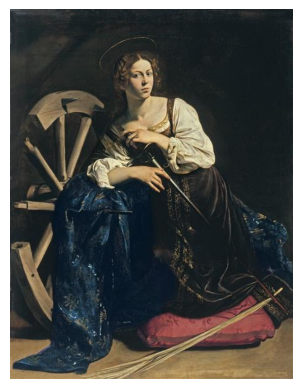

In [48]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(IMAGE_BASE_DIRECTORY + 'full/d0f7553218c8910b8823265f78487f4b35ecab1c.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [40]:
import os

file_path = os.path.join(IMAGE_BASE_DIRECTORY, 'full', '20f1d4bce105c7e84bcc674e5c940bae657d1cb7.jpg')

if os.path.exists(file_path):
    size = os.path.getsize(file_path)
    print(f"File size: {size} bytes")
else:
    print("File does not exist.")

File size: 65060 bytes


#### Delete Orphaned Images

In [61]:
IMAGE_BASE_DIRECTORY = 'data/img/'

In [62]:
# --- Function to delete orphaned files ---
def delete_orphaned_files(orphaned_file_paths, base_directory, log_only=True):
    """
    Deletes a list of orphaned files from the disk.

    Args:
        orphaned_file_paths (set or list): A collection of relative file paths
                                           (e.g., 'full/image.jpg') to be deleted.
                                           This comes from the `disk_orphans` output.
        base_directory (str): The base directory where these relative paths reside.
        log_only (bool): If True, only prints which files would be deleted without
                         actually deleting them. If False, performs deletion.
    """
    if not orphaned_file_paths:
        print("No orphaned files provided to delete.")
        return

    print(f"\n--- {'Logging Deletions (Log Only Mode)' if log_only else 'Attempting to Delete Orphaned Files'} ---")
    if not log_only:
        print("WARNING: PERMANENTLY DELETING FILES FROM DISK!")
        
    deleted_count = 0
    error_count = 0

    for rel_path in tqdm(list(orphaned_file_paths), desc="Processing files for deletion"):
        full_path = os.path.join(base_directory, rel_path)
        
        if log_only:
            if os.path.exists(full_path):
                print(f"[LOG ONLY] Would delete: {full_path}")
            else:
                print(f"[LOG ONLY] File already missing (or path incorrect): {full_path}")
        else: # Actual deletion
            try:
                if os.path.exists(full_path):
                    os.remove(full_path)
                    print(f"DELETED: {full_path}")
                    deleted_count += 1
                else:
                    print(f"File not found, cannot delete: {full_path}")
                    error_count +=1 # Count as an error if we expected to delete it
            except Exception as e:
                print(f"Error deleting file {full_path}: {e}")
                error_count += 1
    
    if log_only:
        print(f"\nLog only mode complete. {len(orphaned_file_paths)} files were logged for potential deletion.")
    else:
        print(f"\nDeletion process complete.")
        print(f"Successfully deleted: {deleted_count} files.")
        if error_count > 0:
            print(f"Errors encountered for: {error_count} files (e.g., not found, permission issues).")


In [68]:
if __name__ == "__main__":
     # --- 1. Load your DataFrame and run reconciliation (as you did) ---
    disk_orphans_to_delete = disk_orphans # In your case, this is the output from reconciliation

     # --- 2. Call the deletion function ---
    if disk_orphans_to_delete:
        # FIRST, RUN WITH log_only=True to see what would be deleted:
        print("\n--- Running in LOG ONLY mode first ---")
        delete_orphaned_files(disk_orphans_to_delete, IMAGE_BASE_DIRECTORY, log_only=True)
        
        # AFTER VERIFYING THE LOG, if you are sure, change log_only to False
        # For demonstration, let's proceed if the user confirms (in a real script)
        # For this example, we'll just show how to call it with log_only=False
        
        print("\n--- TO ACTUALLY DELETE, UNCOMMENT THE NEXT SECTION AND SET log_only=False ---")
        print("--- MAKE SURE YOU HAVE A BACKUP! ---")
        
        # Example of actual deletion call (use with extreme caution):
        confirm_deletion = input("Are you sure you want to delete the logged files? (yes/no): ")
        if confirm_deletion.lower() == 'yes':
            print("\n--- Running in ACTUAL DELETION mode ---")
            delete_orphaned_files(disk_orphans_to_delete, IMAGE_BASE_DIRECTORY, log_only=False)
        else:
            print("Actual deletion cancelled.")

    else:
        print("The `disk_orphans_to_delete` set is empty. No files to process for deletion.")




--- Running in LOG ONLY mode first ---

--- Logging Deletions (Log Only Mode) ---


Processing files for deletion:   0%|          | 0/2807 [00:00<?, ?it/s]

[LOG ONLY] Would delete: data/img/full/bfd396fb4c54130428f87673e7522cf61cc4493f.jpg
[LOG ONLY] Would delete: data/img/full/6058d20f2a75832728999de37eff639bd362ecc3.jpg
[LOG ONLY] Would delete: data/img/full/7b2dfe7d3effe47cdd8861e5b47827c2938137cd.jpg
[LOG ONLY] Would delete: data/img/full/52dcb546ae68e8ed0ff6d1099124623f84ceec1c.jpg
[LOG ONLY] Would delete: data/img/full/ffec03741507eb69be9c346a05eca537560f6f33.jpg
[LOG ONLY] Would delete: data/img/full/6d814608e8c5fb50e942f07b4ff3cdca293d39cc.jpg
[LOG ONLY] Would delete: data/img/full/9e62439a020f09a9748c8ba76cb54fea57219e73.jpg
[LOG ONLY] Would delete: data/img/full/d5856991a31f1928f5079b397a394c0c164358b6.jpg
[LOG ONLY] Would delete: data/img/full/a95529f24481d3c49c08fd2696b21f74461c368c.jpg
[LOG ONLY] Would delete: data/img/full/245f28f2b8082879fc8d168f0a5f2c90f2e88035.jpg
[LOG ONLY] Would delete: data/img/full/dc4827e2aaf7f6593f376d3517ab061822dd4c1d.jpg
[LOG ONLY] Would delete: data/img/full/6094da0c3d4ea12c6f3685f31b8020e61289e

Are you sure you want to delete the logged files? (yes/no):  yes



--- Running in ACTUAL DELETION mode ---

--- Attempting to Delete Orphaned Files ---


Processing files for deletion:   0%|          | 0/2807 [00:00<?, ?it/s]

DELETED: data/img/full/bfd396fb4c54130428f87673e7522cf61cc4493f.jpg
DELETED: data/img/full/6058d20f2a75832728999de37eff639bd362ecc3.jpg
DELETED: data/img/full/7b2dfe7d3effe47cdd8861e5b47827c2938137cd.jpg
DELETED: data/img/full/52dcb546ae68e8ed0ff6d1099124623f84ceec1c.jpg
DELETED: data/img/full/ffec03741507eb69be9c346a05eca537560f6f33.jpg
DELETED: data/img/full/6d814608e8c5fb50e942f07b4ff3cdca293d39cc.jpg
DELETED: data/img/full/9e62439a020f09a9748c8ba76cb54fea57219e73.jpg
DELETED: data/img/full/d5856991a31f1928f5079b397a394c0c164358b6.jpg
DELETED: data/img/full/a95529f24481d3c49c08fd2696b21f74461c368c.jpg
DELETED: data/img/full/245f28f2b8082879fc8d168f0a5f2c90f2e88035.jpg
DELETED: data/img/full/dc4827e2aaf7f6593f376d3517ab061822dd4c1d.jpg
DELETED: data/img/full/6094da0c3d4ea12c6f3685f31b8020e61289e730.jpg
DELETED: data/img/full/d3a257237fef0fe48ac12f94bab9fa93b36ba103.jpg
DELETED: data/img/full/4f08c4de45c48ceecf1bd3bf869aaca78a72f3a1.jpg
DELETED: data/img/full/47b43ca68a205dc7a323d17e3